# 1-3 文本数据建模流程
## 一、数据预处理

In [1]:
import numpy as np
import pandas as pd
from collections import OrderedDict
import re, string

MAX_WORDS = 10000 # 仅考虑最高频的10000个词
MAX_LEN = 200 # 每个样本保留200个词的长度
BATCH_SIZE = 20

train_data_path = './data/imdb/train.tsv'
test_data_path = './data/imdb/test.tsv'

train_token_path = './data/imdb/train_token.tsv'
test_token_path = './data/imdb/test_token.tsv'

train_samples_path = './data/imdb/train_samples/'
test_samples_path = './data/imdb/test_samples/'

### 构建词典

In [2]:
# 构建词典
word_count_dict = {}

# 清洗文本
def clean_text(text):
    lowercase = text.lower().replace('\n', ' ') # '\n' 替换为 ' '
    stripped_html = re.sub('<br />', ' ', lowercase) # '<br />' 替换为 ' '
    cleaned_punctuation = re.sub('[%s]'%re.escape(string.punctuation), '', stripped_html) # 去掉所有标点
    return cleaned_punctuation

# 读入数据并清洗文本，构建词典
with open (train_data_path, 'r', encoding='UTF-8') as f:
    for line in f:
        label, text = line.split('\t')
        cleaned_text = clean_text(text)
        for word in cleaned_text.split(' '):
            word_count_dict[word] = word_count_dict.get(word, 0)+1 #

# 字典转为dataframe, 只有一列, 列名count
df_word_dict = pd.DataFrame(pd.Series(word_count_dict, name = "count")) 
df_word_dict = df_word_dict.sort_values(by = "count", ascending =False) # 降序排列

df_word_dict = df_word_dict[0:MAX_WORDS-2] # 总共取前(MAX_WORDS-2)个词 
df_word_dict["word_id"] = range(2,MAX_WORDS) # 编号0和1分别留给未知词<unkown>和填充<padding>

word_id_dict = df_word_dict["word_id"].to_dict()

df_word_dict.head(10)

,count,word_id
the,268230,2
and,129713,3
a,129479,4
of,116497,5
to,108296,6
is,85615,7
,84074,8
in,74715,9
it,62587,10
i,60837,11


### 根据构建的词典，将文本转换成token序号

In [3]:
# 填充文本
def pad(data_list, pad_length):
    padded_list = data_list.copy()
    
    # 如果超长，截取后pad_length长的文本
    if len(data_list) > pad_length:
        padded_list = data_list[-pad_length:]
        
    # 如果长度不够，从开头开始补1
    if len(data_list) < pad_length:
        padded_list = [1]*(pad_length-len(data_list)) + data_list
    
    return padded_list


def text_to_token(text_file, token_file):
    with open(text_file, 'r', encoding = 'UTF-8') as fin,\
      open(token_file, 'w', encoding = 'UTF-8') as fout:
        for line in fin:
            label,text = line.split("\t")
            cleaned_text = clean_text(text)
            word_token_list = [word_id_dict.get(word, 0) for word in cleaned_text.split(" ")] # 找到每个词的id
            pad_list = pad(word_token_list, MAX_LEN)
            out_line = label + "\t" + " ".join([str(x) for x in pad_list])
            fout.write(out_line + "\n")

text_to_token(train_data_path, train_token_path)
text_to_token(test_data_path, test_token_path)

### 将token文本按照样本分割，每个文件存放一个样本的数据。

In [4]:
import os

# 如果目录不存在则创建目录
if not os.path.exists(train_samples_path):
    os.mkdir(train_samples_path)
    
if not os.path.exists(test_samples_path):
    os.mkdir(test_samples_path)

    
def split_samples(token_path, samples_dir):
    with open(token_path, 'r', encoding = 'UTF-8') as fin:
        i = 0
        for line in fin:
            with open(samples_dir+"%d.txt"%i, 'w', encoding = "UTF-8") as fout:
                fout.write(line)
            i = i + 1

split_samples(train_token_path, train_samples_path)
split_samples(test_token_path, test_samples_path)

In [5]:
print(os.listdir(train_samples_path)[0:100])

['11303.txt', '3644.txt', '19987.txt', '18441.txt', '5235.txt', '17772.txt', '1053.txt', '13514.txt', '8711.txt', '15165.txt', '7422.txt', '8077.txt', '15603.txt', '7344.txt', '1735.txt', '13272.txt', '9369.txt', '18327.txt', '5553.txt', '17014.txt', '4895.txt', '11465.txt', '3122.txt', '19039.txt', '5547.txt', '18333.txt', '17000.txt', '4881.txt', '2228.txt', '11471.txt', '3136.txt', '4659.txt', '15617.txt', '8063.txt', '7350.txt', '12178.txt', '1721.txt', '13266.txt', '14509.txt', '6728.txt', '1047.txt', '13500.txt', '15171.txt', '8705.txt', '7436.txt', '16478.txt', '11317.txt', '3650.txt', '19993.txt', '10009.txt', '5221.txt', '18455.txt', '17766.txt', '3888.txt', '6700.txt', '14247.txt', '9433.txt', '13528.txt', '12636.txt', '15159.txt', '16450.txt', '4117.txt', '19763.txt', '3678.txt', '17996.txt', '2566.txt', '10021.txt', '5209.txt', '17028.txt', '2200.txt', '10747.txt', '11459.txt', '16336.txt', '4671.txt', '19005.txt', '7378.txt', '12150.txt', '1709.txt', '6066.txt', '14521.txt

### 创建数据集Dataset, 从文件名称列表中读取文件内容

In [6]:
import os
import torch
from torch.utils.data import Dataset, DataLoader

class imdbDataset(Dataset):
    # 如果需要自定义Dataset，就需要实现__getitem__（）和 __len__（）方法。
    
    def __init__(self, samples_dir):
        self.samples_dir = samples_dir
        self.samples_paths = os.listdir(samples_dir) # samples_dir下的所有文件，返回文件名list
    
    def __len__(self):
        return len(self.samples_paths) # 返回samples_dir下所有文件个数

    def __getitem__(self, index):
        path = self.samples_dir + '/' + self.samples_paths[index]
        with open(path, 'r', encoding="UTF-8") as f:
            line = f.readline()
            label, tokens = line.split("\t")
            label = torch.tensor([float(label)], dtype = torch.float)
            feature = torch.tensor([int(x) for x in tokens.split(" ")], dtype = torch.long)
            return  (feature, label)


In [7]:
ds_train = imdbDataset(train_samples_path)
ds_test = imdbDataset(test_samples_path)

print(len(ds_train))
print(len(ds_test))

dl_train = DataLoader(ds_train, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
dl_test = DataLoader(ds_test, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

for features, labels in dl_train:
    print(features)
    print(labels.shape)
    break

for features, labels in dl_test:
    print(features.shape)
    print(labels.shape)
    break

20000
5000
tensor([[   1,    1,    1,  ..., 1327, 2778,    8],
        [   1,    1,    1,  ..., 1900,  349,    8],
        [   3,    2,   18,  ...,   20, 2278,    8],
        ...,
        [ 309,    2,  394,  ...,  187, 3740,    8],
        [  20,  998,   49,  ...,    5,  294,    8],
        [   6,   27,    0,  ...,   60,  510,    8]])
torch.Size([20, 1])
torch.Size([20, 200])
torch.Size([20, 1])


# 二、定义模型
使用Pytorch通常有三种方式构建模型：使用nn.Sequential按层顺序构建模型，继承nn.Module基类构建自定义模型，继承nn.Module基类构建模型并辅助应用模型容器(nn.Sequential,nn.ModuleList,nn.ModuleDict)进行封装。

此处选择使用第三种方式进行构建。

由于接下来使用类形式的训练循环，我们将模型封装成torchkeras.Model类来获得类似Keras中高阶模型接口的功能。

Model类实际上继承自nn.Module类。

In [8]:
import torch
from torch import nn 
import torchkeras

In [9]:
torch.random.seed()

class Net(torchkeras.Model):
    
    def __init__(self):
        super(Net, self).__init__()
        
        #设置padding_idx参数后将在训练过程中将填充的token始终赋值为0向量；每个词表示为3维向量
        self.embedding = nn.Embedding(num_embeddings=MAX_WORDS, embedding_dim=3, padding_idx=1)
        
        self.conv = nn.Sequential()
        self.conv.add_module("conv_1", nn.Conv1d(in_channels = 3, out_channels = 16, kernel_size = 5)) 
        # in_channels = embedding dim; real kernel size =  kernel_size * in_channels
        
        self.conv.add_module("pool_1", nn.MaxPool1d(kernel_size = 2))
        self.conv.add_module("relu_1", nn.ReLU())
        self.conv.add_module("conv_2", nn.Conv1d(in_channels = 16, out_channels = 128, kernel_size = 2))
        self.conv.add_module("pool_2", nn.MaxPool1d(kernel_size = 2)) # default stride = 2
        self.conv.add_module("relu_2", nn.ReLU())
        
        self.dense = nn.Sequential()
        self.dense.add_module("flatten", nn.Flatten())
        self.dense.add_module("linear", nn.Linear(6144, 1)) # 128*48=6144 ??
        self.dense.add_module("sigmoid", nn.Sigmoid())
        
    def forward(self, x):
        # after embedding: (batch_size=20, MAX_LEN=200, embedding_dim=3)
        # transpose: (20, 3, 200)
        
        # conv1: (20, out_channels=16, 200-5+1=196)
        # maxpool1d of conv1: (20, 16, 196) -> (20, 16, 196/2=98)
        
        # conv2: (20, 16, 98) -> (20, 128, 98-2+1=97)
        # maxpool1d of conv2: (20, 128, 97) -> (20, 128, 97/2=48)
        
        x = self.embedding(x).transpose(1, 2)
        x = self.conv(x)
        y = self.dense(x)
        return y

model = Net()
print(model)

model.summary(input_shape = (200,), input_dtype = torch.LongTensor)

Net(
  (embedding): Embedding(10000, 3, padding_idx=1)
  (conv): Sequential(
    (conv_1): Conv1d(3, 16, kernel_size=(5,), stride=(1,))
    (pool_1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (relu_1): ReLU()
    (conv_2): Conv1d(16, 128, kernel_size=(2,), stride=(1,))
    (pool_2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (relu_2): ReLU()
  )
  (dense): Sequential(
    (flatten): Flatten()
    (linear): Linear(in_features=6144, out_features=1, bias=True)
    (sigmoid): Sigmoid()
  )
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         Embedding-1               [-1, 200, 3]          30,000
            Conv1d-2              [-1, 16, 196]             256
         MaxPool1d-3               [-1, 16, 98]               0
              ReLU-4               [-1, 16, 98]               0
            Conv1d-5              [-1, 128, 97]  

# 三、训练模型
训练Pytorch通常需要用户编写自定义训练循环，训练循环的代码风格因人而异。

有3类典型的训练循环代码风格：脚本形式训练循环，函数形式训练循环，类形式训练循环。

此处介绍一种类形式的训练循环。

我们仿照Keras定义了一个高阶的模型接口Model,实现 fit, validate，predict, summary 方法，相当于用户自定义高阶API。

In [10]:
# 准确率 acc = y_pred预测正确的（=y_true）/ 样本总数
# torch.abs绝对值
# e.g. y_true=[01001] y_pred=[10010] 1-torch.abs(y_true-y_pred)=[00100] acc=0.4
# torch.where(condition, x, y) → Tensor 如果满足条件返回x

def accuracy(y_pred, y_true):
    y_pred = torch.where(y_pred > 0.5, 
                         torch.ones_like(y_pred, dtype=torch.float32), 
                         torch.zeros_like(y_pred, dtype=torch.float32))
    acc = torch.mean(1-torch.abs(y_true-y_pred))
    return acc

model.compile(loss_func=nn.BCELoss(), 
              optimizer=torch.optim.Adagrad(model.parameters(), lr = 0.02), 
              metrics_dict={"accuracy":accuracy})

In [11]:
# 有时候模型训练过程中不收敛，需要多试几次
# fit函数说明：fit(epochs, dl_train, dl_val=None, log_step_freq=1) 
# 1个step对应1个batch，200step=4000条数据 共1000step/20000条训练数据

epochs = 20
dfhistory = model.fit(epochs, dl_train, dl_val=dl_test, log_step_freq=200) 

Start Training ...

================================================================================2020-11-03 22:43:34
{'step': 200, 'loss': 0.87, 'accuracy': 0.499}
{'step': 400, 'loss': 0.78, 'accuracy': 0.513}
{'step': 600, 'loss': 0.748, 'accuracy': 0.53}
{'step': 800, 'loss': 0.729, 'accuracy': 0.542}
{'step': 1000, 'loss': 0.716, 'accuracy': 0.553}

 +-------+-------+----------+----------+--------------+
| epoch |  loss | accuracy | val_loss | val_accuracy |
+-------+-------+----------+----------+--------------+
|   1   | 0.716 |  0.553   |  0.653   |    0.609     |
+-------+-------+----------+----------+--------------+

================================================================================2020-11-03 22:43:54
{'step': 200, 'loss': 0.637, 'accuracy': 0.638}
{'step': 400, 'loss': 0.631, 'accuracy': 0.642}
{'step': 600, 'loss': 0.63, 'accuracy': 0.642}
{'step': 800, 'loss': 0.626, 'accuracy': 0.646}
{'step': 1000, 'loss': 0.621, 'accuracy': 0.65}

 +-------+-------+------

{'step': 600, 'loss': 0.272, 'accuracy': 0.891}
{'step': 800, 'loss': 0.273, 'accuracy': 0.889}
{'step': 1000, 'loss': 0.27, 'accuracy': 0.89}

 +-------+------+----------+----------+--------------+
| epoch | loss | accuracy | val_loss | val_accuracy |
+-------+------+----------+----------+--------------+
|   14  | 0.27 |   0.89   |  0.487   |    0.782     |
+-------+------+----------+----------+--------------+

================================================================================2020-11-03 22:47:43
{'step': 200, 'loss': 0.243, 'accuracy': 0.906}
{'step': 400, 'loss': 0.251, 'accuracy': 0.903}
{'step': 600, 'loss': 0.253, 'accuracy': 0.9}
{'step': 800, 'loss': 0.253, 'accuracy': 0.9}
{'step': 1000, 'loss': 0.256, 'accuracy': 0.898}

 +-------+-------+----------+----------+--------------+
| epoch |  loss | accuracy | val_loss | val_accuracy |
+-------+-------+----------+----------+--------------+
|   15  | 0.256 |  0.898   |  0.486   |    0.783     |
+-------+-------+--------

# 四、评估模型

In [12]:
dfhistory

,loss,accuracy,val_loss,val_accuracy
0,0.715770,0.55265,0.653083,0.6086
1,0.620581,0.65005,0.602718,0.6750
2,0.566285,0.70465,0.569150,0.7036
3,0.519577,0.74480,0.544156,0.7216
4,0.478630,0.77035,0.546436,0.7244
5,0.442084,0.79330,0.507246,0.7468
6,0.410388,0.81325,0.501941,0.7554
7,0.382426,0.82960,0.506751,0.7572
8,0.358888,0.84330,0.502669,0.7608
9,0.336997,0.85545,0.485914,0.7700


In [13]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg' 
import matplotlib.pyplot as plt

def plot_metric(dfhistory, metric):
    train_metrics = dfhistory[metric]
    val_metrics = dfhistory['val_' + metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics, 'bo--')
    plt.plot(epochs, val_metrics, 'ro-')
    plt.title('Training and validation ' + metric)
    plt.xlabel('Epochs')
    plt.ylabel(metric)
    plt.legend(['train_' + metric, 'val_' + metric])
    plt.show()

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


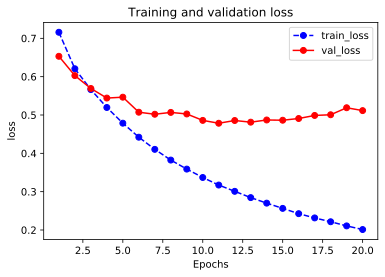

In [14]:
plot_metric(dfhistory, 'loss')

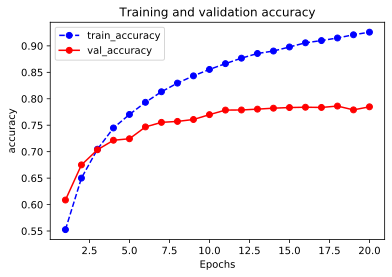

In [15]:
plot_metric(dfhistory, "accuracy")

In [16]:
# 评估
model.evaluate(dl_test)

{'val_loss': 0.5114321528375149, 'val_accuracy': 0.7848000011444092}

# 五、使用模型

In [17]:
model.predict(dl_test)

tensor([[0.0114],
        [0.9782],
        [0.0039],
        ...,
        [0.7721],
        [0.5360],
        [0.4816]])

# 六、保存模型

In [18]:
# 保存模型参数
print(model.state_dict().keys())

odict_keys(['embedding.weight', 'conv.conv_1.weight', 'conv.conv_1.bias', 'conv.conv_2.weight', 'conv.conv_2.bias', 'dense.linear.weight', 'dense.linear.bias'])


In [19]:
torch.save(model.state_dict(), './result/1-3/model_parameter.pkl')
model_clone = Net()
model_clone.load_state_dict(torch.load('./result/1-3/model_parameter.pkl'))
model_clone.compile(loss_func = nn.BCELoss(), optimizer = torch.optim.Adagrad(model.parameters(),lr = 0.02),
             metrics_dict={"accuracy":accuracy})

model_clone.predict(dl_test)

tensor([[0.0114],
        [0.9782],
        [0.0039],
        ...,
        [0.7721],
        [0.5360],
        [0.4816]])